# Content
MLR classifier models of Dividing v. Differentiating cells
1. Model of birth frame
2. Model of mother division frame
3. Model of mother division frame - group 1diff and 2diff daughters
4. Model of mother division frame -12h

## 0. Load datasets

In [5]:
# Core libraries
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import seaborn as sb

# General utils
from tqdm import tqdm
from os import path

from sklearn import preprocessing, model_selection
from sklearn import metrics, inspection, linear_model

def get_balanced_df_by_category(df,category):
    # assert(logical.dtype == bool)
    
    # Find the category with least members
    categories = {cat:mem for cat, mem in df.groupby(category)}
    num_per_category = np.array([len(mem) for mem in categories.values()])
    smallest_category = list(categories.keys())[num_per_category.argmin()]
    
    output = []
    for cat, member in categories.items():
        if cat == smallest_category:
            output.append(member)
        else:
            output.append(member.sample(num_per_category.min()))
    output = pd.concat(output,ignore_index=True)

    return output


In [2]:
dirnames = {'R1':'/Users/xies/OneDrive - Stanford/Skin/Mesa et al/W-R1/',
           'R2':'/Users/xies/OneDrive - Stanford/Skin/Mesa et al/W-R2/'}
all_df = []
for name,dirname in dirnames.items():
    _df = pd.read_pickle(path.join(dirname,'Mastodon/single_timepoints_dynamics_aggregated_lookback_history.pkl'))
    _df = _df.drop_duplicates().sort_index().reset_index()
    _df['TrackID'] = name + '_' + _df['TrackID'].astype(str)
    _df = _df.set_index(['Frame','TrackID'])
    _df['Region'] = name
    all_df.append(_df)

all_df = pd.concat(all_df)
all_tracks = {trackID:t for trackID,t in all_df.reset_index().groupby('TrackID')}


In [3]:
len(all_tracks)
all_df['Region']

Frame  TrackID
0      R1_1       R1
       R1_2       R1
       R1_5       R1
       R1_8       R1
       R1_11      R1
                  ..
14     R2_1163    R2
       R2_1173    R2
       R2_1175    R2
       R2_1193    R2
       R2_1198    R2
Name: Region, Length: 15087, dtype: object

## 1. Categorize cell from its birth frame
1. Isolate birth frame data
2. Categorize will differentiate v. will divide

In [9]:
df = all_df[all_df['Fate known','Meta']]
df = df[ ~df['Border','Meta'].astype(bool)]
df = df[ df['Cell type','Meta'] == 'Basal']

births = df[df['Birth frame','Meta']]
births[('Relative basal area','Measurement')] = \
    births['Basal area','Measurement'] / births['Mean adjac Basal area','Measurement']
# births['bbox top - diff','Measurement'] = \
#     births['Nuclear bbox top','Measurement'] - births['Z','Measurement']
# births['bbox bottom - diff','Measurement'] = \
#     births['Nuclear bbox bottom','Measurement']-births['Z','Measurement']
births_raw = births.copy()

features2drop = [f for f in births.columns.get_level_values(0) if 'Time to differentiation' in f]
# Censor height information
features2drop = features2drop + ['Z','Mean curvature - cell coords','Z-cyto','Height to BM',
                                 'Basal area','Apical area']
# Censor all exponential rates (but not mother's)
features2drop = features2drop + [f for f in births.columns.get_level_values(0)
                                 if ('exponential' in f and 'frame prior' not in f \
                                         and 'adjac' not in f)]
births = births.drop(columns=features2drop).dropna(axis=1)


/var/folders/zp/5k1kvm9j0t19cvq8h628kr8h0000gn/T/ipykernel_78242/1579744986.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  births[('Relative basal area','Measurement')] = \
/var/folders/zp/5k1kvm9j0t19cvq8h628kr8h0000gn/T/ipykernel_78242/1579744986.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  births[('Relative basal area','Measurement')] = \
/var/folders/zp/5k1kvm9j0t19cvq8h628kr8h0000gn/T/ipykernel_78242/1579744986.py:22: PerformanceWarning: dropping on a non-lexsorted multi-index without a level paramete

In [10]:
X = births.xs('Measurement',level=1,axis=1).astype(float).T
X.loc[X.std(axis=1) == 0].index

Index(['Age'], dtype='object', name='Name')

In [19]:

Niter = 100
metas = pd.DataFrame()
metas['name'] = births.xs('Meta',level=1,axis=1).columns
features = pd.DataFrame()

measurements = births.xs('Measurement',level=1,axis=1)
features['name'] = measurements.columns
features =features.set_index('name')
features['Num NA'] = measurements.isna().sum(axis=0)
# features = features.drop(features.loc[features.index.str.startswith('cyto_')].index)

feature_names = features.index
importances = pd.DataFrame(columns=feature_names,index=range(Niter))
avg_confusion = np.zeros((Niter,2,2))

for i in tqdm(range(Niter)):
    
    df_ = get_balanced_df_by_category(births, births['Will differentiate','Meta'].values)
    
    y = df_['Will differentiate','Meta']
    X = df_.xs('Measurement',level=1,axis=1).astype(float)
    X = preprocessing.scale(X)
    
    X_train,X_test,y_train,y_test = model_selection.train_test_split(X,y)
    
    forest = linear_model.LogisticRegression(penalty='elasticnet',solver='saga').fit(X_train,y_train)
    
    y_pred = forest.predict(X_test)
    avg_confusion[i,...] = metrics.confusion_matrix(y_test,y_pred)/len(y_test)

    perm_imps = inspection.permutation_importance(forest, X, y)
    importances.loc[i] = perm_imps.importances_mean
    

100%|█████████████████████████████████████████| 100/100 [05:11<00:00,  3.12s/it]


### Plot birth frame category

name
nuc_shcoeffs_L4M4C                                           0.000756
Median adjac cyto_shcoeffs_L5M1C at 1 frame prior            0.000789
Median adjac NC ratio at 1 frame prior                       0.000842
cyto_shcoeffs_L5M2S                                          0.000878
Std adjac Distance to closest macrophage at 1 frame prior    0.000935
Min adjac nuc_shcoeffs_L3M3C at 1 frame prior                0.001009
cyto_shcoeffs_L5M3S                                          0.001048
nuc_shcoeffs_L2M2S                                           0.001051
nuc_shcoeffs_L5M5C                                           0.001077
Cell volume smoothed                                         0.001143
Nuclear solidity                                             0.001187
cyto_shcoeffs_L5M5S                                          0.001363
Relative Height to BM at 1 frame prior                       0.001577
cyto_shcoeffs_L5M4C                                          0.001658
Gaussian curvat

Text(0, 0.5, 'Feature importance')

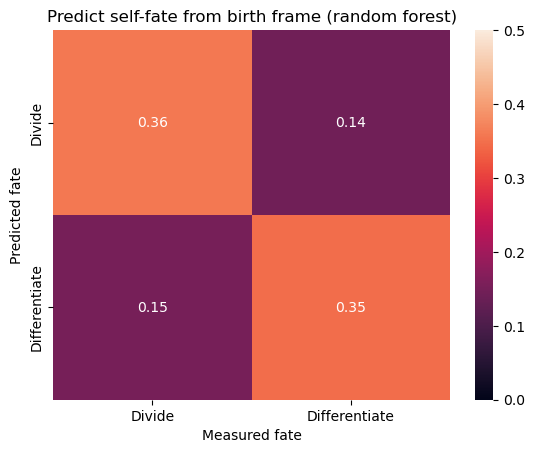

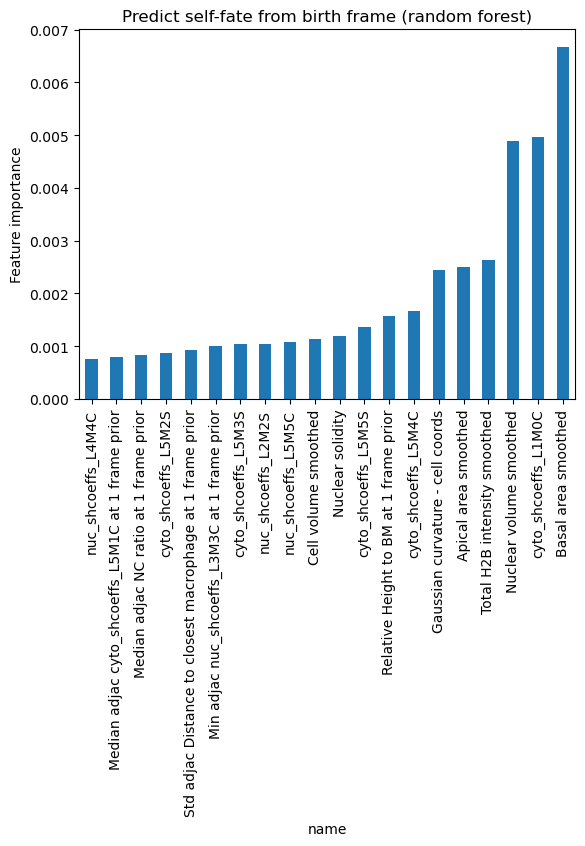

In [15]:

plt.title('Predict self-fate from birth frame (random forest)')
sb.heatmap(avg_confusion.mean(axis=0),annot=True,vmin=0,vmax=0.5)
plt.gca().set_xticks([0.5,1.5],labels=['Divide','Differentiate'])
plt.gca().set_yticks([0.5,1.5],labels=['Divide','Differentiate'])
plt.xlabel('Measured fate')
plt.ylabel('Predicted fate')

plt.figure()
plt.title('Predict self-fate from birth frame (random forest)')
print(importances.mean().sort_values().tail(20))
importances.mean().sort_values().tail(20).plot.bar();
plt.ylabel('Feature importance')


/opt/miniconda3/envs/python39/lib/python3.9/site-packages/seaborn/categorical.py:3399: UserWarning: 6.5% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/opt/miniconda3/envs/python39/lib/python3.9/site-packages/seaborn/categorical.py:3399: UserWarning: 5.8% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


/opt/miniconda3/envs/python39/lib/python3.9/site-packages/seaborn/categorical.py:3399: UserWarning: 6.1% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


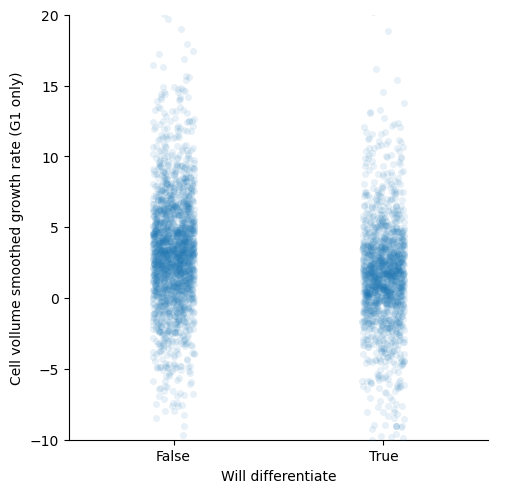

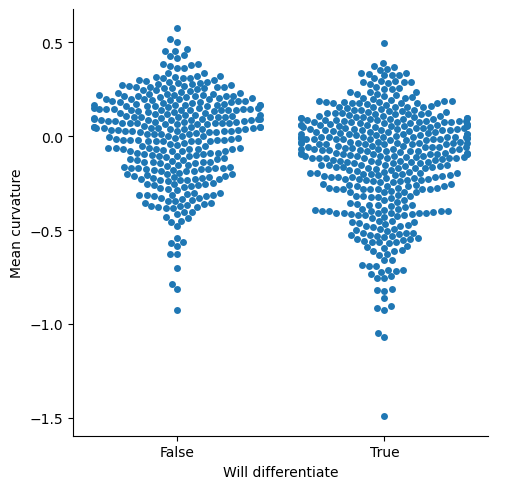

In [70]:
# Visualize features

sb.catplot(all_df[all_df['Fate known','Meta'] & (all_df['Cell cycle phase','Meta'] == 'G1')].droplevel(level=1,axis=1),
           x='Will differentiate',y='Cell volume smoothed growth rate',kind='strip',alpha=0.1)
plt.ylim([-10,20]); plt.ylabel('Cell vollume smoothed growth rate (G1 only)')

# sb.catplot(births_raw.droplevel(level=1,axis=1),x='Will differentiate',y='Cell volume exponential growth rate')

sb.catplot(births_raw.droplevel(level=1,axis=1),x='Will differentiate',y='Mean curvature',kind='swarm')


## 2. Predict daughter fate from mother division frame
Daughter fate: 0 delaminating, 1 delaminating or 2 delaminating

In [72]:
BALANCE = True
Niter = 100

# feature2predict = 'At least one daughter differentiated'
# feature2predict = 'Both daughters differentiated'
feature2predict = 'Num daughter differentiated'

df = all_df[all_df['Fate known','Meta']]
df = df[ df['Cell type','Meta'] == 'Basal']

divisions = df[df[('Divide next frame','Meta')]]
divisions = divisions[~divisions['Border','Meta'].astype(bool)]
divisions = divisions.reset_index().set_index('TrackID')


In [73]:
{f:df[f].max() for f in all_df.droplevel(axis=1,level=1).columns if 'Relative' in f}

{'Relative Nuclear volume': Metadata
 Measurement    2.634456
 dtype: float64,
 'Relative Nuclear solidity': Metadata
 Measurement    1.495262
 dtype: float64,
 'Relative Nuclear height': Metadata
 Measurement    1.666667
 dtype: float64,
 'Relative Cell volume': Metadata
 Measurement    2.622328
 dtype: float64,
 'Relative Axial component': Metadata
 Measurement    3.125253
 dtype: float64,
 'Relative Planar component 1': Metadata
 Measurement    2.593523
 dtype: float64,
 'Relative Planar component 2': Metadata
 Measurement    2.763843
 dtype: float64,
 'Relative Axial angle': Metadata
 Measurement    7.375199
 dtype: float64,
 'Relative Planar angle': Metadata
 Measurement    4.749641
 dtype: float64,
 'Relative Mean H2B intensity': Metadata
 Measurement    1.292439
 dtype: float64,
 'Relative Total H2B intensity': Metadata
 Measurement    2.672646
 dtype: float64,
 'Relative Mean FUCCI intensity': Metadata
 Measurement    1.978294
 dtype: float64,
 'Relative Total FUCCI intensity':

In [74]:

features2drop = [f for f in df.columns.get_level_values(0) if 'Time' in f]
features2drop += [f for f in df.columns.get_level_values(0) if 'Age' in f]
features2drop += [f for f in df.columns.get_level_values(0) if 'prior' in f]

features2drop = [(f,'Measurement') for f in features2drop]
features2drop = features2drop + [('Keep until first differentiation','Meta')]
divisions = divisions.drop(columns=features2drop).dropna(
    subset=[(feature2predict,'Meta')])

feature_names = divisions.xs('Measurement',axis=1,level=1).columns
importances = pd.DataFrame(columns=feature_names)
avg_confusion = np.zeros((Niter,3,3))

for i in tqdm(range(Niter)):
    
    if BALANCE:
        df_ = get_balanced_df_by_category(divisions,
                                          divisions[(feature2predict,'Meta')].values)
    else:
        df_ = divisions
        
    _tmp = df_.xs('Measurement',level=1,axis=1).copy()
    _tmp[feature2predict] = df_[(feature2predict,'Meta')].copy()
    
    y = _tmp[feature2predict].values
    X = preprocessing.scale(_tmp.drop(columns=feature2predict))
    
    X_train,X_test,y_train,y_test = model_selection.train_test_split(X,y,test_size=0.1)
    
    forest = ensemble.RandomForestClassifier().fit(X_train,y_train)
    
    y_pred = forest.predict(X_test)
    avg_confusion[i,...] = metrics.confusion_matrix(y_test,y_pred)/len(y_test)
    
    importances.loc[i] = forest.feature_importances_
    

100%|█████████████████████████████████████████| 100/100 [00:14<00:00,  6.91it/s]


In [77]:
_df.droplevel(level=1,axis=1).groupby(feature2predict).count()

Name,Nuclear volume,Nuclear solidity,Z,Y,X,Nuclear height,Cell volume,Z-cyto,Y-cyto,X-cyto,...,Mean adjac nuc_shcoeffs_L1M1C at 1 frame prior,Mean adjac Basal area at 1 frame prior,Median adjac Cell volume at 1 frame prior,Mean adjac Mean curvature - cell coords at 1 frame prior,Median adjac Height to BM at 1 frame prior,Num neighbor division 1 frame prior,Num neighbor delamination 1 frame prior,At least one daughter differentiated,Both daughters differentiated,Region
Num daughter differentiated,,,,,,,,,,,,,,,,,,,,,
0.0,177,177,177,177,177,177,177,177,177,177,...,142,142,142,142,142,138,138,177,177,177
1.0,249,249,249,249,249,249,249,249,249,249,...,186,186,186,186,186,163,163,250,250,250
2.0,213,213,213,213,213,213,213,213,213,213,...,182,182,182,182,182,168,168,213,213,213


Name
Mean adjac nuc_shcoeffs_L1M0C          0.002780
Relative nuc_shcoeffs_surface_area     0.002829
Relative cyto_shcoeffs_surface_area    0.002872
Relative Nuclear volume                0.002911
nuc_shcoeffs_L3M2S                     0.002920
Relative Nuclear volume standard       0.002938
Mean adjac Cell volume standard        0.003083
Relative nuc_shcoeffs_L0M0C            0.003277
nuc_shcoeffs_L1M0C                     0.003436
Relative Mean H2B intensity            0.003588
Median adjac Cell volume standard      0.003905
Mean curvature                         0.004083
Height to BM                           0.004513
Mean curvature - cell coords           0.005654
Relative Total H2B intensity           0.005777
Basal area                             0.008083
cyto_shcoeffs_L3M0C                    0.008269
Basal area smoothed                    0.008868
Relative Basal area                    0.011797
Relative Height to BM                  0.015128
dtype: float64


Text(24.847222222222214, 0.5, 'Feature importance')

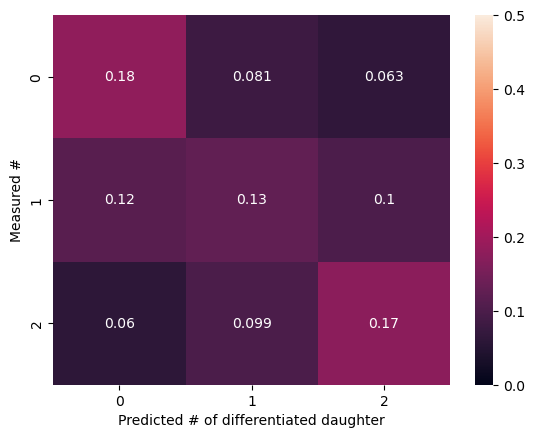

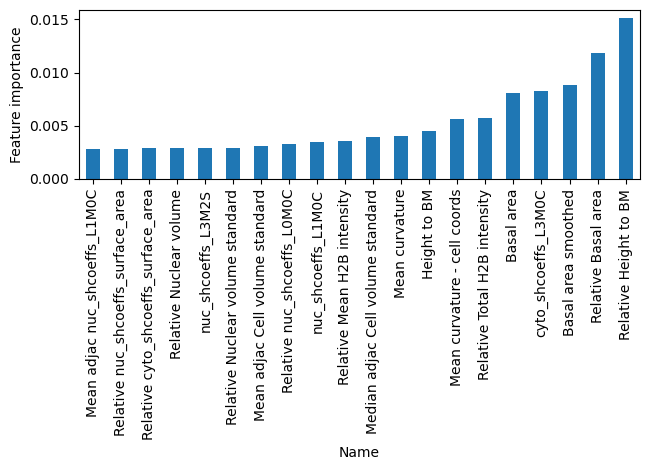

In [78]:
# Plot mother division model results
sb.heatmap(avg_confusion.mean(axis=0),annot=True,vmin=0,vmax=0.5)
plt.xlabel('Predicted # of differentiated daughter')
plt.ylabel('Measured #')
print(importances.mean().sort_values().tail(20))

plt.figure()
importances.mean().sort_values().tail(20).plot.bar(); plt.tight_layout();
plt.ylabel('Feature importance')


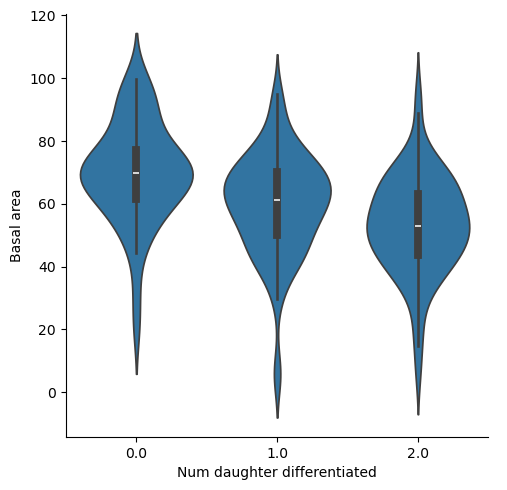

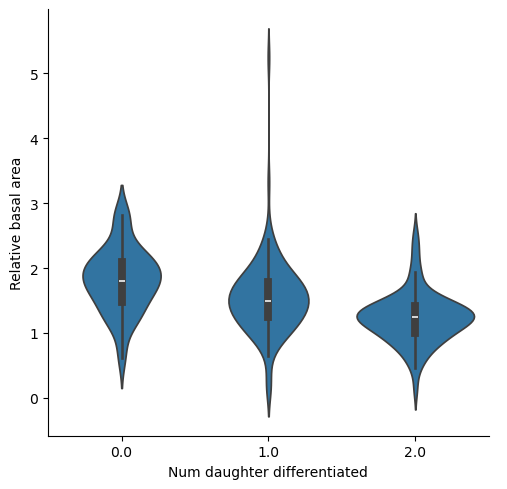

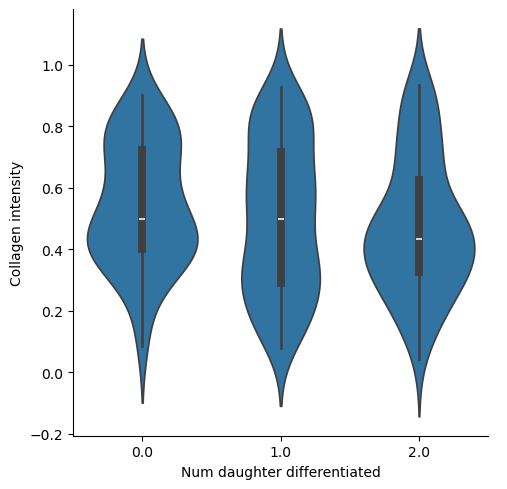

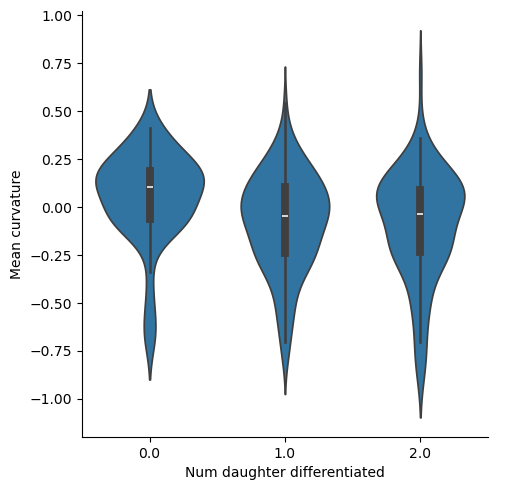

In [51]:
# Visualize features

sb.catplot(divisions.droplevel(level=1,axis=1),x='Num daughter differentiated',y='Basal area',kind='violin')
sb.catplot(divisions.droplevel(level=1,axis=1),x='Num daughter differentiated',y='Relative basal area',kind='violin')
sb.catplot(divisions.droplevel(level=1,axis=1),x='Num daughter differentiated',y='Collagen intensity',kind='violin')
sb.catplot(divisions.droplevel(level=1,axis=1),x='Num daughter differentiated',y='Mean curvature',kind='violin')

## 3. Mother divsion -> predict all stem v. any diff daughters

In [79]:
BALANCE = True
Niter = 100

feature2predict = 'At least one daughter differentiated'
# feature2predict = 'Both daughters differentiated'
# feature2predict = 'Num daughter differentiated'

df = all_df[all_df['Fate known','Meta']]
df = df[ df['Cell type','Meta'] == 'Basal']

divisions = df[df[('Divide next frame','Meta')]]
divisions = divisions[~divisions['Border','Meta'].astype(bool)]
divisions = divisions.reset_index().set_index('TrackID')

features2drop = [f for f in df.columns.get_level_values(0) if 'Time' in f]
features2drop += [f for f in df.columns.get_level_values(0) if 'Age' in f]
features2drop += [f for f in df.columns.get_level_values(0) if 'prior' in f]

features2drop = [(f,'Measurement') for f in features2drop]
features2drop = features2drop + [('Keep until first differentiation','Meta')]
divisions = divisions.drop(columns=features2drop).dropna(
    subset=[(feature2predict,'Meta')])

feature_names = divisions.xs('Measurement',axis=1,level=1).columns
importances = pd.DataFrame(columns=feature_names)
avg_confusion = np.zeros((Niter,2,2))

In [80]:

for i in tqdm(range(Niter)):
    
    if BALANCE:
        df_ = get_balanced_df_by_category(divisions,
                                          divisions[(feature2predict,'Meta')].values)
    else:
        df_ = divisions
        
    _tmp = df_.xs('Measurement',level=1,axis=1).copy()
    _tmp[feature2predict] = df_[(feature2predict,'Meta')].copy()
    
    y = _tmp[feature2predict].values.astype(bool)
    X = preprocessing.scale(_tmp.drop(columns=feature2predict))
    
    X_train,X_test,y_train,y_test = model_selection.train_test_split(X,y,test_size=0.1)
    
    forest = ensemble.RandomForestClassifier().fit(X_train,y_train)
    
    y_pred = forest.predict(X_test)
    avg_confusion[i,...] = metrics.confusion_matrix(y_test,y_pred)/len(y_test)
    
    importances.loc[i] = forest.feature_importances_
    

100%|█████████████████████████████████████████| 100/100 [00:09<00:00, 10.42it/s]


Name
Relative Nuclear volume standard           0.003280
Median adjac cyto_shcoeffs_L5M5S           0.003330
Axial component                            0.003362
Relative Distance to closest macrophage    0.003382
Relative nuc_shcoeffs_L0M0C                0.003731
Relative Nuclear volume                    0.003754
Relative nuc_shcoeffs_surface_area         0.003798
Relative Total H2B intensity               0.004045
Mean adjac Cell volume standard            0.004065
cyto_shcoeffs_L1M0C                        0.004317
nuc_shcoeffs_L1M0C                         0.004328
Median adjac Cell volume standard          0.004533
Height to BM                               0.005805
Mean curvature                             0.005863
Basal area smoothed                        0.007107
Basal area                                 0.007145
Mean curvature - cell coords               0.007380
Relative Basal area                        0.009510
cyto_shcoeffs_L3M0C                        0.010734
Relativ

Text(24.847222222222214, 0.5, 'Feature importance')

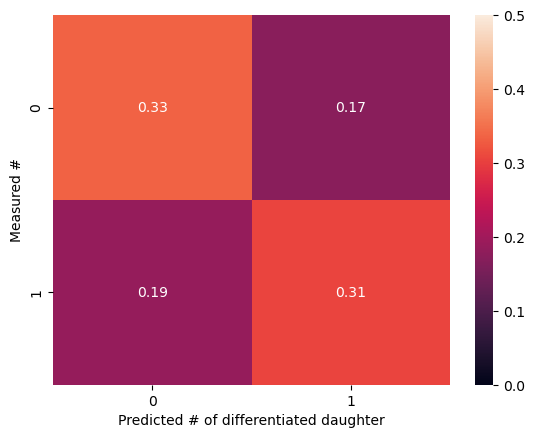

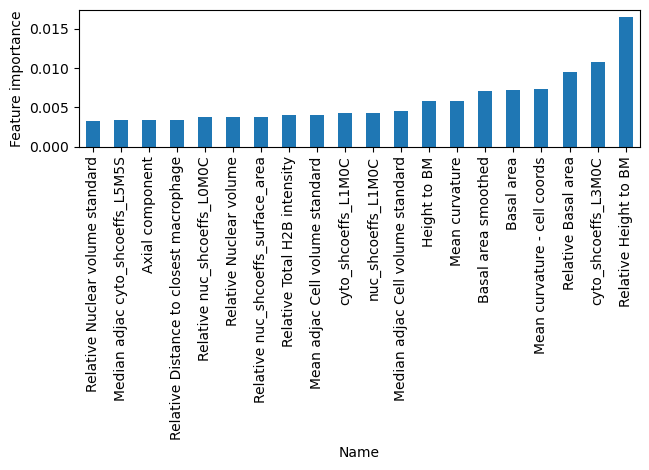

In [36]:
# Plot mother division model results
sb.heatmap(avg_confusion.mean(axis=0),annot=True,vmin=0,vmax=0.5)
plt.xlabel('Predicted # of differentiated daughter')
plt.ylabel('Measured #')
print(importances.mean().sort_values().tail(20))

plt.figure()
importances.mean().sort_values().tail(20).plot.bar(); plt.tight_layout();
plt.ylabel('Feature importance')


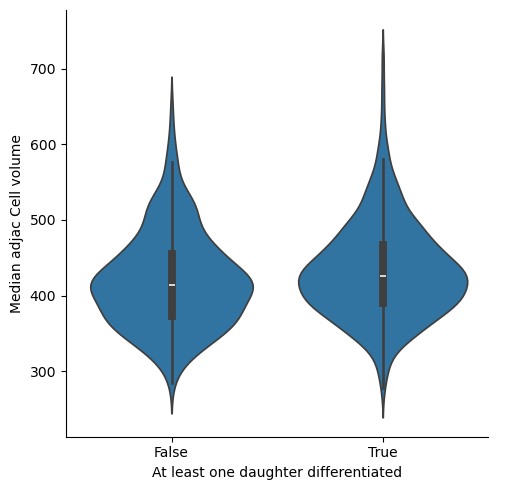

In [58]:
sb.catplot(df.droplevel(axis=1,level=1),x=feature2predict,y='Median adjac Cell volume',kind='violin')

## 4. 12h prior to mother division frame
- NB: Not enough cells

In [38]:
# Grab frame prior to mother division -- takes a while
from measurements import get_prev_or_next_frame

BALANCE = True
Niter = 100

df = all_df[all_df['Fate known','Meta']]
df = df[ df['Cell type','Meta'] == 'Basal']

divisions = df[df[('Divide next frame','Meta')]]
divisions = divisions[~divisions['Border','Meta'].astype(bool)]
divisions = divisions.reset_index()

prev_div_frame = [get_prev_or_next_frame(df,f,direction='prev') for _,f in tqdm(divisions.iterrows())]
prev_div_frame = pd.concat(prev_div_frame,axis=1,ignore_index=False).T
prev_div_frame = prev_div_frame[~prev_div_frame['Border','Meta'].astype(bool)]
prev_div_frame = prev_div_frame.reset_index().rename(columns={'level_0':'Frame','level_1':'TrackID'}).set_index('TrackID')

len(prev_div_frame)

668it [00:00, 827.42it/s]


586

In [39]:
prev_div_frame

Name,Frame,Nuclear volume,Nuclear solidity,Z,Y,X,Nuclear height,Cell volume,Z-cyto,Y-cyto,...,Std adjac nuc_shcoeffs_L0M3S at 1 frame prior,Median adjac cyto_shcoeffs_L3M5S at 1 frame prior,Mean adjac nuc_shcoeffs_L0M4S at 1 frame prior,Median adjac nuc_shcoeffs_L2M5C at 1 frame prior,Max adjac nuc_shcoeffs_L0M3C at 1 frame prior,Min adjac Reviewed by at 1 frame prior,Min adjac cyto_shcoeffs_L4M5S at 1 frame prior,Max adjac cyto_shcoeffs_L2M3S at 1 frame prior,Std adjac cyto_shcoeffs_L0M5C at 1 frame prior,Min adjac cyto_shcoeffs_L3M5S at 1 frame prior
Metadata,,Measurement,Measurement,Measurement,Measurement,Measurement,Measurement,Measurement,Measurement,Measurement,...,Measurement,Measurement,Measurement,Measurement,Measurement,Measurement,Measurement,Measurement,Measurement,Measurement
TrackID,,,,,,,,,,,,,,,,,,,,,
R1_24,0,152.1875,0.8972,45.391786,6.102977,79.960164,-9.0,599.6875,45.946326,5.960787,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
R1_47,0,170.9375,0.852822,46.041316,72.345612,91.721389,-12.0,622.375,46.556337,72.414491,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
R1_80,0,168.1875,0.879124,47.824601,87.936919,41.629413,-12.0,615.5,47.501726,87.820014,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
R1_177,0,187.5,0.894454,48.291333,36.524417,94.357667,-12.0,576.8125,47.655542,36.566123,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
R1_321,0,214.3125,0.906184,48.60105,90.007947,33.835156,-11.0,548.25,48.98974,90.042037,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
R2_388,12,146.375,0.910575,55.160974,23.949402,16.922822,-10.0,466.375,54.892656,24.297641,...,0.0,0.0,0.0,0.0,0.0,False,0.0,0.0,0.0,0.0
R2_529,12,155.6875,0.900904,57.584103,17.018065,24.705339,-8.0,594.5625,57.454746,17.138784,...,0.0,0.0,0.0,0.0,0.0,False,0.0,0.0,0.0,0.0


In [40]:
feature2predict = 'At least one daughter differentiated'
# feature2predict = 'Both daughters differentiated'
# feature2predict = 'Num daughter differentiated'

# Drop unneeded features
features2drop = [f for f in prev_div_frame.columns.get_level_values(0) if 'Time' in f]
features2drop += [f for f in prev_div_frame.columns.get_level_values(0) if 'Age' in f]
features2drop = [(f,'Measurement') for f in features2drop]
features2drop = features2drop + [('Keep until first differentiation','Meta')]
# divisions = prev_div_frame.drop(columns=features2drop).dropna(subset=[(feature2predict,'Meta')])

# Run model
feature_names = prev_div_frame.xs('Measurement',axis=1,level=1).columns
importances = []
avg_confusion = np.zeros((Niter,2,2))

for i in tqdm(range(Niter)):
    
    if BALANCE:
        df_ = get_balanced_df_by_category(prev_div_frame, prev_div_frame[(feature2predict,'Meta')].values).dropna(axis=1)
    else:
        df_ = prev_div_frame

    _tmp = df_.xs('Measurement',level=1,axis=1).copy()
    _tmp[feature2predict] = df_[(feature2predict,'Meta')].copy()
    
    y = _tmp[feature2predict].values.astype(bool)
    X = preprocessing.scale(_tmp.drop(columns=feature2predict))
    
    X_train,X_test,y_train,y_test = model_selection.train_test_split(X,y,test_size=0.1)
    
    forest = ensemble.RandomForestClassifier().fit(X_train,y_train)
    
    y_pred = forest.predict(X_test)
    avg_confusion[i,...] = metrics.confusion_matrix(y_test,y_pred)/len(y_test)
    
    importances.append(forest.feature_importances_)

importances = pd.DataFrame(importances,columns=_tmp.columns.drop('At least one daughter differentiated'))


100%|█████████████████████████████████████████| 100/100 [00:13<00:00,  7.16it/s]


Name
Median adjac cyto_shcoeffs_L4M2C         0.003234
nuc_shcoeffs_L5M3S                       0.003282
nuc_shcoeffs_surface_area                0.003362
Median adjac cyto_shcoeffs_L4M4C         0.003380
nuc_shcoeffs_L5M0C                       0.003457
cyto_shcoeffs_L3M1S                      0.003528
Std adjac nuc_shcoeffs_L3M2C             0.003607
Std adjac nuc_shcoeffs_L4M3S             0.003684
nuc_shcoeffs_L3M3S                       0.003908
Mean curvature                           0.003940
Relative nuc_shcoeffs_L0M0C              0.004255
cyto_shcoeffs_L4M0C                      0.004265
Relative Mean curvature - cell coords    0.004395
Min adjac Mean H2B intensity             0.004475
Relative Axial component                 0.004637
Mean curvature - cell coords             0.004756
Height to BM                             0.005316
Relative Mean H2B intensity              0.006035
Relative Height to BM                    0.008094
cyto_shcoeffs_L1M0C                      0.00

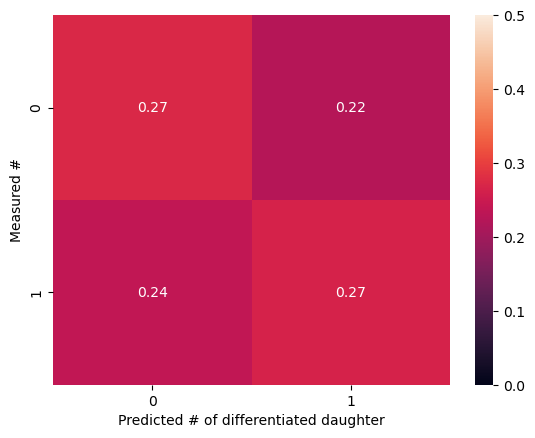

In [41]:
sb.heatmap(avg_confusion.mean(axis=0),annot=True,vmin=0,vmax=0.5)
plt.xlabel('Predicted # of differentiated daughter')
plt.ylabel('Measured #')
print(importances.mean().sort_values().tail(20))


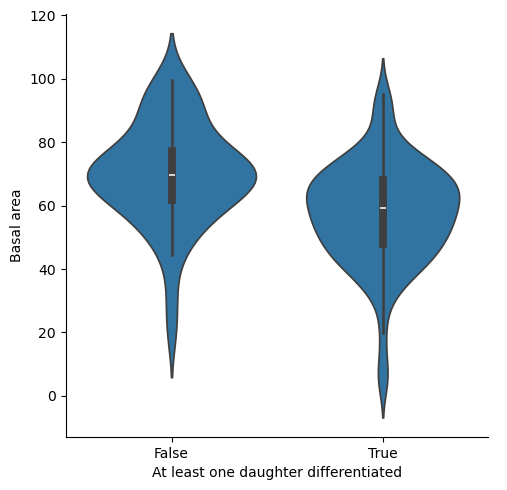

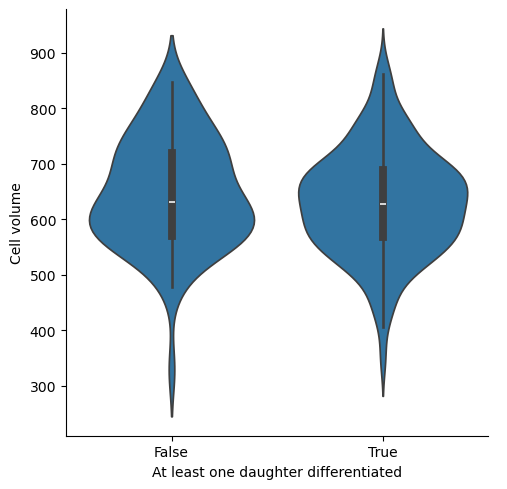

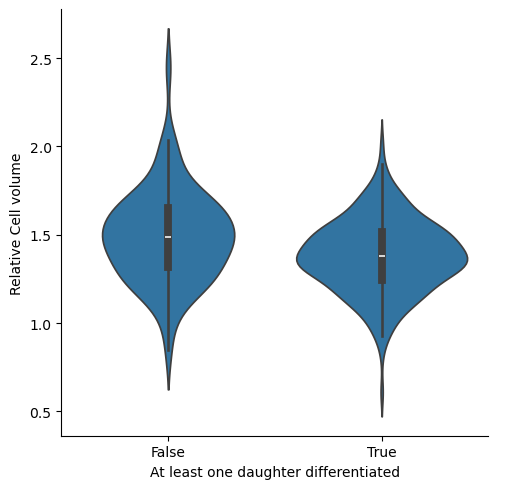

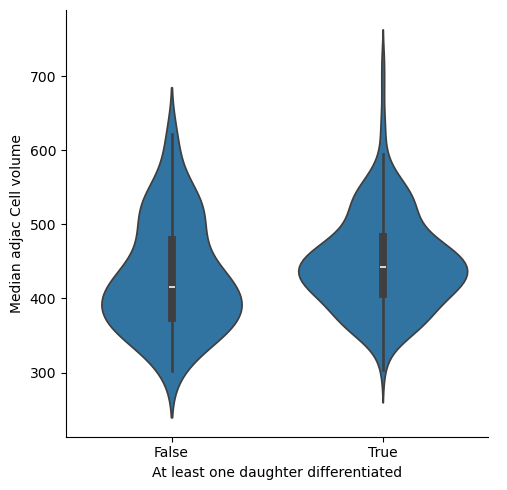

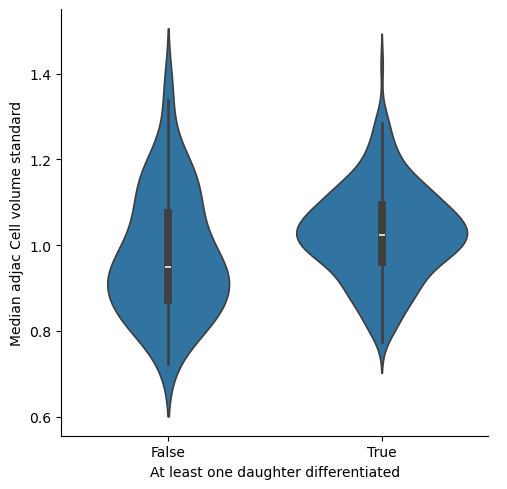

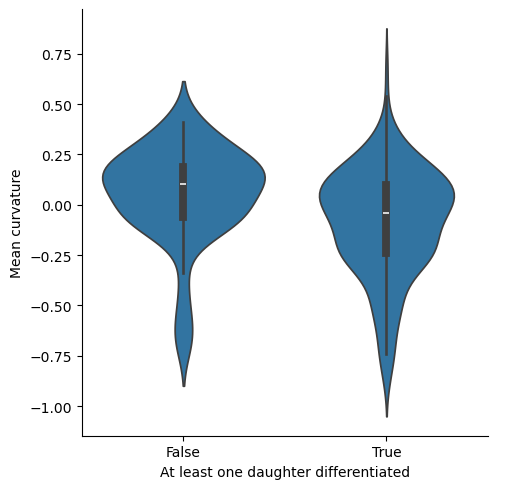

In [59]:

# Visualize features

sb.catplot(prev_div_frame.droplevel(level=1,axis=1),x=feature2predict,y='Basal area',kind='violin')
sb.catplot(prev_div_frame.droplevel(level=1,axis=1),x=feature2predict,y='Cell volume',kind='violin')
sb.catplot(prev_div_frame.droplevel(level=1,axis=1),x=feature2predict,y='Relative Cell volume',kind='violin')
sb.catplot(prev_div_frame.droplevel(level=1,axis=1),x=feature2predict,y='Median adjac Cell volume',kind='violin')
sb.catplot(prev_div_frame.droplevel(level=1,axis=1),x=feature2predict,y='Median adjac Cell volume standard',kind='violin')
# sb.catplot(prev_div_frame.droplevel(level=1,axis=1),x=feature2predict,y='Collagen intensity',kind='violin')
sb.catplot(prev_div_frame.droplevel(level=1,axis=1),x=feature2predict,y='Mean curvature',kind='violin')

## 5. 24h prior to mother division

In [31]:
# Grab frame prior to mother division
from measurements import get_prev_or_next_frame

BALANCE = True
Niter = 100

df = all_df[all_df['Fate known','Meta']]
df = df[ df['Cell type','Meta'] == 'Basal']

divisions = df[df[('Divide next frame','Meta')]]
divisions = divisions[~divisions['Border','Meta'].astype(bool)]
divisions = divisions.reset_index()

prev2_div_frame = [get_prev_or_next_frame(all_df,f,direction='prev', increment=2) for _,f in tqdm(divisions.iterrows())]
prev2_div_frame = pd.concat(prev2_div_frame,axis=1).T
prev2_div_frame = prev2_div_frame[~prev2_div_frame['Border','Meta'].astype(bool)]

len(prev2_div_frame)

668it [00:00, 941.61it/s] 


538

In [42]:
feature2predict = 'At least one daughter differentiated'
# feature2predict = 'Both daughters differentiated'
# feature2predict = 'Num daughter differentiated'

# Drop unneeded features
features2drop = [f for f in prev2_div_frame.columns.get_level_values(0) if 'Time' in f]
features2drop += [f for f in prev2_div_frame.columns.get_level_values(0) if 'Age' in f]
features2drop = [(f,'Measurement') for f in features2drop]
features2drop = features2drop + [('Keep until first differentiation','Meta')]

# Run model
feature_names = prev2_div_frame.xs('Measurement',axis=1,level=1).columns
importances = []
avg_confusion = np.zeros((Niter,2,2))

for i in tqdm(range(Niter)):
    
    if BALANCE:
        df_ = get_balanced_df_by_category(prev2_div_frame, prev2_div_frame[(feature2predict,'Meta')].values)
    else:
        df_ = prev_div_frame

    _tmp = df_.xs('Measurement',level=1,axis=1).copy()
    _tmp[feature2predict] = df_[(feature2predict,'Meta')].copy()
    
    y = _tmp[feature2predict].values.astype(bool)
    X = preprocessing.scale(_tmp.drop(columns=feature2predict))
    
    X_train,X_test,y_train,y_test = model_selection.train_test_split(X,y,test_size=0.1)
    
    forest = ensemble.RandomForestClassifier().fit(X_train,y_train)
    
    y_pred = forest.predict(X_test)
    avg_confusion[i,...] = metrics.confusion_matrix(y_test,y_pred)/len(y_test)
    
    importances.append(forest.feature_importances_)

importances = pd.DataFrame(importances,columns=_tmp.columns.drop(feature2predict))


/opt/miniconda3/envs/python39/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:243: RuntimeWarning: Mean of empty slice
  mean_ = np.nanmean(X, axis)
/opt/miniconda3/envs/python39/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/opt/miniconda3/envs/python39/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:251: RuntimeWarning: Mean of empty slice
  mean_1 = np.nanmean(Xr, axis=0)
/opt/miniconda3/envs/python39/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:258: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
/opt/miniconda3/envs/python39/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:270: RuntimeWarning: Mean of empty slice
  mean_2 = np.nanmean(Xr, axis=0)
/opt/miniconda3/envs/pyt

Name
Relative Nuclear volume             0.002341
Median adjac nuc_shcoeffs_L5M5C     0.002370
nuc_shcoeffs_L2M0C                  0.002433
Mean adjac nuc_shcoeffs_L5M5C       0.002454
Mean curvature                      0.002537
Basal alignment                     0.002735
Relative Nuclear volume standard    0.002752
Basal area smoothed growth rate     0.002758
Std adjac cyto_shcoeffs_L2M1C       0.002841
Min adjac nuc_shcoeffs_L5M5C        0.002862
Mean curvature - cell coords        0.003101
Relative Total H2B intensity        0.003110
Basal alignment smoothed            0.003392
Relative Height to BM               0.003678
Relative nuc_shcoeffs_L0M0C         0.003757
Relative Mean H2B intensity         0.003901
Height to BM                        0.004390
Basal area                          0.004710
Relative Basal area                 0.005151
Basal area smoothed                 0.006915
dtype: float64


Text(24.847222222222214, 0.5, 'Feature importance')

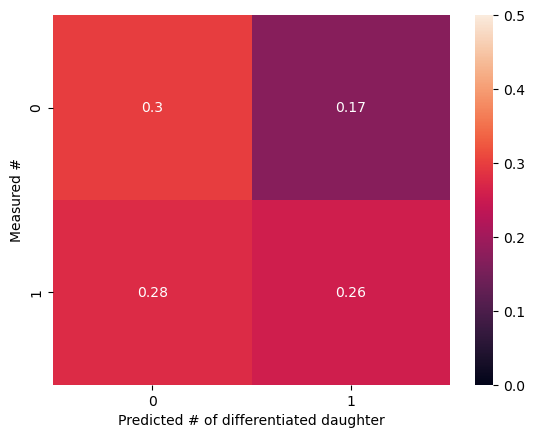

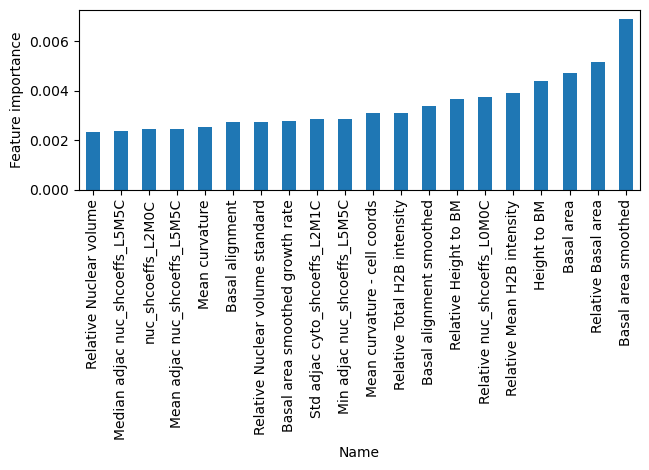

In [43]:
sb.heatmap(avg_confusion.mean(axis=0),annot=True,vmin=0,vmax=0.5)
plt.xlabel('Predicted # of differentiated daughter')
plt.ylabel('Measured #')
print(importances.mean().sort_values().tail(20))

plt.figure()
importances.mean().sort_values().tail(20).plot.bar(); plt.tight_layout();
plt.ylabel('Feature importance')

NameError: name 'pandas' is not defined

## MISC: visualizations

<Figure size 640x480 with 0 Axes>

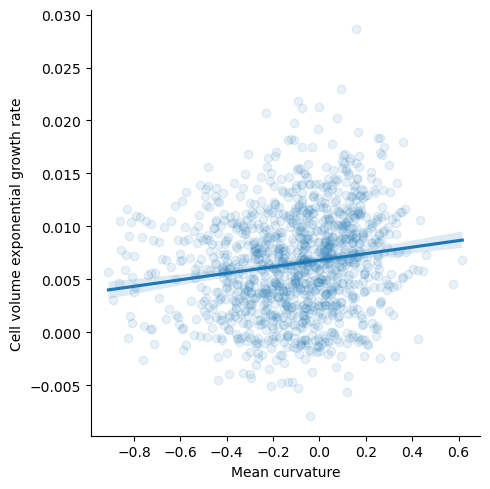

<Figure size 640x480 with 0 Axes>

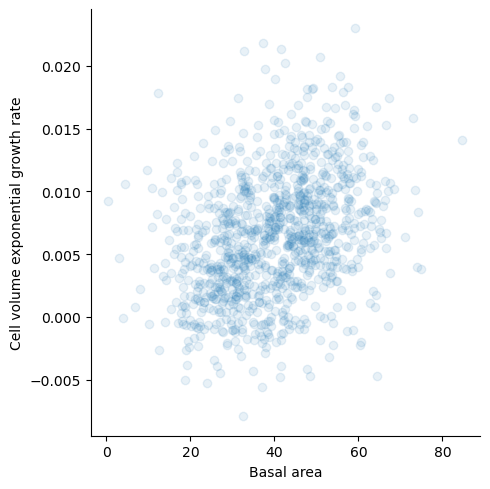

In [141]:
plt.figure()
x = 'Mean curvature'
y = 'Cell volume exponential growth rate'
sb.lmplot(all_df.droplevel(axis=1,level=1)[[x,y]].groupby('TrackID').mean(),x=x,y=y,
          scatter_kws={'alpha':0.1})

plt.figure()
x = 'Basal area'
y = 'Cell volume exponential growth rate'
sb.lmplot(all_df.droplevel(axis=1,level=1)[[x,y]].groupby('TrackID').mean(),x=x,y=y,
          scatter_kws={'alpha':0.1}, fit_reg=False)

In [227]:
features2drop = [f for f in all_df.droplevel(axis=1,level=1).columns if 'smoothed' in f]
features2drop += [f for f in all_df.droplevel(axis=1,level=1).columns if 'shcoeffs' in f]
features2drop += [f for f in all_df.droplevel(axis=1,level=1).columns if 'prior' in f]
features2drop += [f for f in all_df.droplevel(axis=1,level=1).columns if 'standard' in f]
features2drop += [f for f in all_df.droplevel(axis=1,level=1).columns if 'BM' in f]
features2drop += [f for f in all_df.droplevel(axis=1,level=1).columns if 'intensity' in f]
features2drop += [f for f in all_df.droplevel(axis=1,level=1).columns if 'Time' in f]
A = all_df.droplevel(axis=1,level=1).drop(
    columns=['X','X-pixels','Y','Y-pixels','X-cyto','Y-cyto','Z','Z-cyto',
             'Daughter a','Daughter b','Mother','Sister']+features2drop).select_dtypes(numerics).corr(numeric_only=True)

B = A.abs().unstack().sort_values(ascending=False)

unique_pairs = []
# Iterate over the top pairs and add only unique pairs to the list
for pair in B.index:
    if pair[0] != pair[1] and (pair[1], pair[0]) not in unique_pairs:
        unique_pairs.append(pair)

# Create a dataframe with the top pairs and their correlation coefficients
corr_df = pd.DataFrame(columns=['feature_1', 'feature_2', 'corr_coef'])
for i, pair in enumerate(unique_pairs):
    corr_df.loc[i] = [pair[0], pair[1], B.loc[pair[0], pair[1]]]

display(corr_df.dropna().head(50))


,feature_1,feature_2,corr_coef
0,Nuclear bbox bottom,Nuclear bbox top,0.979166
1,Nuclear volume exponential growth rate,Nuclear volume (filter_name) exponential growt...,0.919772
2,Cell volume exponential growth rate,Cell volume (filter_name) exponential growth rate,0.904737
3,Planar component 2,Planar component 1,0.823052
4,Axial component,Middle area,0.747579
5,Right,Left,0.747405
6,Mean curvature - cell coords,Nuclear bbox bottom,0.742856
7,Nuclear volume,Cell volume,0.731716
8,Nuclear bbox top,Mean curvature - cell coords,0.714124
9,Cell height,Planar component 1,0.693165
